In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread, mmwrite

In [12]:
projdir = '/u/home/t/terencew/project-cluo/demux_benchmark/adelus_2023/'
donors = list(np.loadtxt(f'{projdir}/txt/donors.txt', dtype=str))
samples = list(np.loadtxt(f'{projdir}/txt/samples.txt', dtype=str))
new_samples = [x.replace('MT_', 'MT-').replace('pooled_','pooled-') for x in samples]
s = samples[0]

gex_methods = ['demuxlet', 'freemuxlet', 'vireo', 'vireo_nogenos',
               'scsplit', 'scsplit_nogenos',
    'souporcell', 'souporcell_nogenos', 'demuxalot']
atac_methods = ['demuxlet', 'freemuxlet',  'vireo', 'vireo_nogenos',
               'scsplit', 'scsplit_nogenos',
    'souporcell', 'souporcell_nogenos', 'scavengers']

con_cols = ['C1', 'C2', 'I1', 'I2']

In [13]:
h_donors = list(np.loadtxt(f'{projdir}/txt/donors.txt', dtype=str))
mt13_donors = list(np.loadtxt(f'{projdir}/txt/MT1-3_donors.txt', dtype=str))
mt4_donors = list(np.loadtxt(f'{projdir}/txt/MT4_donors.txt', dtype=str))
mt5_donors = list(np.loadtxt(f'{projdir}/txt/MT5_donors.txt', dtype=str))

In [14]:
gex = pd.read_csv(f'{projdir}/csv/demux/inter_gex_raw_donors.csv', sep='\t',
                  header=0, index_col=0)
atac = pd.read_csv(f'{projdir}/csv/demux/inter_atac_raw_donors.csv', sep='\t',
                   header=0, index_col=0)
gex.shape, atac.shape

gex['sample'] = [x.split('_')[1] for x in gex.index]
atac['sample'] = [x.split('_')[1] for x in atac.index]

# gex = gex[gex['sample'] == s]
# atac = atac[atac['sample'] == s]

gex = gex.drop(columns=['sample'])
atac = atac.drop(columns=['sample'])

gex.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)
atac.replace({'doublet' : 'non_singlet' , 'unassigned' : 'non_singlet'}, inplace=True)

gex.shape, atac.shape

((35201, 9), (35201, 9))

In [15]:
tmp_gex = gex.copy()
tmp_atac = atac.copy()
tmp_gex['inter'] = gex.eq(gex.iloc[:, 0], axis=0).all(1)
tmp_atac['inter'] = atac.eq(atac.iloc[:, 0], axis=0).all(1)

gex['inter'] = tmp_gex['inter']
atac['inter'] = tmp_atac['inter']

tmp_gex = gex.iloc[:,:7]
tmp_gex.columns = [f'gex_{x}' for x in tmp_gex.columns]
tmp_atac = atac.iloc[:,:6]
tmp_atac.columns = [f'atac_{x}' for x in tmp_atac.columns]
 
merged = pd.concat([tmp_gex, tmp_atac], axis=1)
merged['inter'] = merged.eq(merged.iloc[:, 0], axis=0).all(1)

In [16]:
gex_mask = ~gex['inter']
unique_gex = gex[gex_mask]

atac_mask = ~atac['inter']
unique_atac = atac[atac_mask]

all_mask = ~merged['inter']
unique_all = gex[all_mask]
unique_gex.shape, unique_atac.shape, unique_all.shape

((20033, 10), (14414, 10), (16061, 10))

In [17]:
gex_unique = pd.DataFrame(index=gex_methods, columns=['n_drops'], data=0)
for method in gex_methods:
    mask = gex[method] != 'non_singlet'
    method_gex = gex[mask]
    gex_unique.loc[method] = method_gex.shape[0] - np.sum(method_gex['inter'])
gex_unique['method'] = gex_unique.index
gex_unique['mod'] = 'gex'

In [18]:
atac_unique = pd.DataFrame(index=atac_methods, columns=['n_drops'], data=0)
for method in atac_methods:
    mask = atac[method] != 'non_singlet'
    method_atac = atac[mask]
    atac_unique.loc[method] = method_atac.shape[0] - np.sum(method_atac['inter'])
atac_unique['method'] = atac_unique.index
atac_unique['mod'] = 'atac'

In [19]:
merged_unique = pd.concat([gex_unique, atac_unique])
merged_unique

,n_drops,method,mod
demuxlet,9823,demuxlet,gex
freemuxlet,19948,freemuxlet,gex
vireo,15007,vireo,gex
vireo_nogenos,16409,vireo_nogenos,gex
scsplit,16351,scsplit,gex
scsplit_nogenos,16177,scsplit_nogenos,gex
souporcell,17365,souporcell,gex
souporcell_nogenos,17282,souporcell_nogenos,gex
demuxalot,14168,demuxalot,gex
demuxlet,8443,demuxlet,atac


Text(0.5, 1.0, 'Aorta dataset')

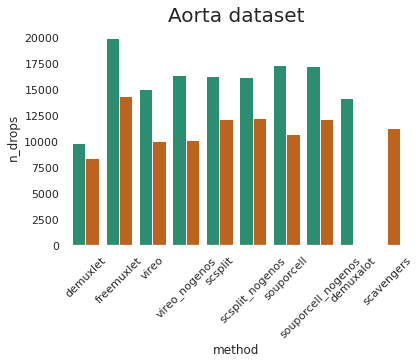

In [20]:
sns.set_theme(palette='Dark2')
ax = sns.barplot(merged_unique, x='method', y='n_drops', hue='mod')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_visible(False)
ax.grid(False)
ax.set_facecolor('white')
ax.set_title('Aorta dataset', size=20)

In [28]:
merged_unique.reset_index(drop=True, inplace=True)
merged_unique.loc[18] = ['0', 'scavengers', 'gex']
merged_unique.loc[19] = ['0', 'demuxalot', 'atac']

In [29]:
merged_unique.to_csv(f'{projdir}/csv/final_figures/figure6/unique_drops.csv', sep='\t', header=True, index=True)